# Pipeline de Validación

Cargamos las tablas de validación desde el github. Estas contienen track_features y playlists de las 50 playlists con más canciones del dataset de 2000 playlists. Ya se encuentran limpiadas (ambas tablas sólo contienen info de canciones de menos de 15 minutos y sin valores nulos).

In [1]:
import pandas as pd
import numpy as np

from recommenders import validar_lista, validar_recomendador, Recommender1, Recommender2, Recommender3

In [2]:
playlists_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_playlists_validation.csv')
tracks_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_tracks_validation.csv')
artist_info = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/artist/2000_artist_sample.csv.gz')

# Se genera set de pids (playlist id) únicos
pids = list(set(playlists_val["pid"]))

cols=tracks_val.columns
tracks_val.columns=[col[15:] if col[:15]=="audio_features." else col for col in cols]
tracks_val = tracks_val.drop(columns=["Unnamed: 0"])
tracks_val.head(n=2)

,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,spotify:track:3RCT90rX7F5rSwMwUU4Pz6,0.616,0.850,5,-5.419,0,0.0580,0.00216,0.0667,0.181,0.470,142.841,audio_features,3RCT90rX7F5rSwMwUU4Pz6,https://api.spotify.com/v1/tracks/3RCT90rX7F5r...,https://api.spotify.com/v1/audio-analysis/3RCT...,219560,4
1,spotify:track:2t5GyUfFoZg3E8ak3i7dVP,0.301,0.353,4,-15.588,0,0.0467,0.77800,0.4890,0.406,0.189,134.588,audio_features,2t5GyUfFoZg3E8ak3i7dVP,https://api.spotify.com/v1/tracks/2t5GyUfFoZg3...,https://api.spotify.com/v1/audio-analysis/2t5G...,621107,3


`var_names` para obtener los features que nos sirven y `tracks_info` para obtener información de una canción dada una `uri`

In [3]:
var_names=["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
tracks_info = playlists_val.drop_duplicates(subset=["track_uri"]).set_index("track_uri")[["track_name", "artist_name"]].loc[tracks_val["uri"]]

Definir clases para cada recomendador y así poder evaluarlos. Colocarlas en el espacio y formato del siguiente 
_template_:

```python
#Colocar acá las clases de sus clasificadores.
#Pueden o no tener init o train, pero deben tener una función recommend_list
class RecommenderX:
    def __init__(self):
        pass
    #Puede no tener train, dependiendo de cómo funcione. Pero debe utilizar las canciones dentro del dataset de validación.
    def train(self, tracks_df, playlists_df):
        pass
    #Esta función DEBE tomar como input un dataframe de canciones.
    #Debe tambien tomar el argumento "number" para setear el número de recomendaciones
    def recommend_list(self, canciones_df, number=100, **kwargs):
        #DEBE retornar una lista de uris de las canciones output 
        return None
```

Calculamos la métrica en los datos de validación. Para una lista dada, se eligen aleatoreamente 20 canciones que pertenezcan a la lista y se obtienen N-20 recomendaciones, donde N es la cantidad de canciones de la lista (las listas del dataset de validación tienen entre 210-375 canciones). Luego, evalúa qué porcentaje de las N-20 canciones output pertenecen a la lista original. Repite este proceso. Se grafica el histograma de desempeño del recomendador.

Las clases y funciones auxiliares se encuentran disponbiles en el archivo <a href="https://github.com/alcazar90/CC5205-3-proyecto/blob/main/sandbox/recommenders.py">recommenders.py</a>

## Sistema de Recomendación 1: Matriz de próximidad

El modelo requiere memorizar el vector de características promedio de cada lista en el set de entrenamiento.
Por lo tanto, se debe cruzar la tabla con la información de las listas con los _track features_ de cada una 
de las canciones que contienen las _playlists_, para luego agregarlas en un vector promedio de _track features_ por lista.

In [4]:
avg_features_by_pid = \
        playlists_val \
            .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
            [['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
            .groupby('pid') \
            .mean() \
            .reset_index()

In [5]:
features_by_pid_plus_artist = \
    playlists_val \
    .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
    [['pid','artist_uri', 'track_uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
    .drop_duplicates(subset=['artist_uri']) \
    .merge(artist_info[['artists.uri', 'artists.popularity']], left_on='artist_uri', right_on='artists.uri', how='left') \
    .drop(['artists.uri'], axis=1)

In [6]:
recomendador_1 = Recommender1(avg_features_by_pid)
recomendador_1.fit(avg_features_by_pid.iloc[:, 1:].to_numpy(), 
                   avg_features_by_pid.iloc[:, 0].to_numpy(),
                   features_by_pid_plus_artist)

Generando recomendaciones Playlist 5 de 50. % Recomendaciones correctas: 0.0
Generando recomendaciones Playlist 10 de 50. % Recomendaciones correctas: 1.55
Generando recomendaciones Playlist 15 de 50. % Recomendaciones correctas: 6.7
Generando recomendaciones Playlist 20 de 50. % Recomendaciones correctas: 1.92
Generando recomendaciones Playlist 25 de 50. % Recomendaciones correctas: 0.48
Generando recomendaciones Playlist 30 de 50. % Recomendaciones correctas: 0.53
Generando recomendaciones Playlist 35 de 50. % Recomendaciones correctas: 1.75
Generando recomendaciones Playlist 40 de 50. % Recomendaciones correctas: 3.16
Generando recomendaciones Playlist 45 de 50. % Recomendaciones correctas: 1.55
Generando recomendaciones Playlist 50 de 50. % Recomendaciones correctas: 2.82
Eficiencia promedio Recomendador 1: 2.13 %


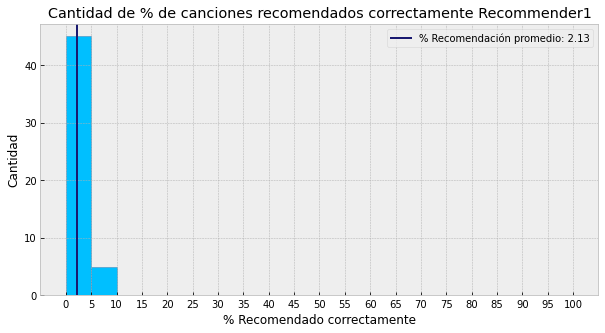

In [7]:
np.random.seed(1991)
eficiencia_1=validar_recomendador(playlists_val, tracks_val, pids, recomendador_1)
print("Eficiencia promedio Recomendador 1:", round(eficiencia_1, 2),"%")

## Sistema de Recomendación 2: Multi-label logistic regression

In [8]:
recomendador_2=Recommender2(var_names)
recomendador_2.train(tracks_val, playlists_val)

0
10
20
30
40


Generando recomendaciones Playlist 5 de 50. % Recomendaciones correctas: 86.7
Generando recomendaciones Playlist 10 de 50. % Recomendaciones correctas: 6.7
Generando recomendaciones Playlist 15 de 50. % Recomendaciones correctas: 23.44
Generando recomendaciones Playlist 20 de 50. % Recomendaciones correctas: 24.04
Generando recomendaciones Playlist 25 de 50. % Recomendaciones correctas: 3.33
Generando recomendaciones Playlist 30 de 50. % Recomendaciones correctas: 3.68
Generando recomendaciones Playlist 35 de 50. % Recomendaciones correctas: 7.02
Generando recomendaciones Playlist 40 de 50. % Recomendaciones correctas: 15.79
Generando recomendaciones Playlist 45 de 50. % Recomendaciones correctas: 7.77
Generando recomendaciones Playlist 50 de 50. % Recomendaciones correctas: 14.55
Eficiencia recomendador 2: 15.527872250831512 %


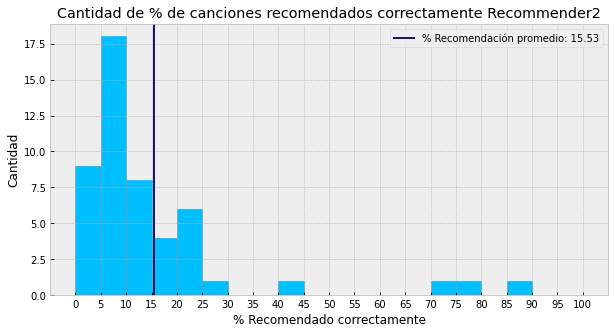

In [9]:
np.random.seed(1991)
eficiencia_2=validar_recomendador(playlists_val, tracks_val, pids, recomendador_2)
print("Eficiencia recomendador 2:", eficiencia_2,"%")

## Sistema de Recomendación 3: Autoencoder

In [10]:
recomendador_3 = Recommender3(var_names)
recomendador_3.load_data(tracks_val)

Generando recomendaciones Playlist 5 de 50. % Recomendaciones correctas: 63.3
Generando recomendaciones Playlist 10 de 50. % Recomendaciones correctas: 10.31
Generando recomendaciones Playlist 15 de 50. % Recomendaciones correctas: 8.13
Generando recomendaciones Playlist 20 de 50. % Recomendaciones correctas: 11.54
Generando recomendaciones Playlist 25 de 50. % Recomendaciones correctas: 10.95
Generando recomendaciones Playlist 30 de 50. % Recomendaciones correctas: 8.95
Generando recomendaciones Playlist 35 de 50. % Recomendaciones correctas: 9.65
Generando recomendaciones Playlist 40 de 50. % Recomendaciones correctas: 13.16
Generando recomendaciones Playlist 45 de 50. % Recomendaciones correctas: 9.84
Generando recomendaciones Playlist 50 de 50. % Recomendaciones correctas: 12.21
Eficiencia recomendador 3: 13.61543580982773 %


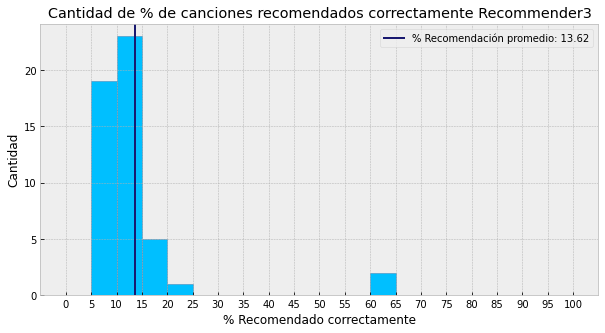

In [11]:
np.random.seed(1991)
eficiencia_3 = validar_recomendador(playlists_val, tracks_val, pids, recomendador_3)
print("Eficiencia recomendador 3:", eficiencia_3,"%")